# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
# Paso 1: Instalación de dependencias en el terminal, ejecutando el comando 'pip install pandas requests' y luego ejecutar

import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



In [2]:
#Paso 2: Descargar HTML

url = 'https://ycharts.com/companies/TSLA/revenues'

html_data = requests.get(url,time.sleep(7)).text
if "403 ERROR" in html_data:
    #para indicar que no es un robot sino que un usuario desde una pagina standar
    headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    request = requests.get(url,headers=headers)
    time.sleep(7)
    html_data = request.text

html_data


'\n\n\n\n\n\n\n\n\n<!doctype html>\n<html lang="en" ng-jq>\n    <head>\n        <title>\n        Tesla Revenue (Quarterly) Analysis | YCharts\n        </title>\n\n        <meta name="viewport" content="width=device-width, initial-scale=1.0" />\n<!-- This code allows us to correctly display the page on mobile devices -->\n<script defer>\n    var viewport = document.querySelector(\'meta[name=viewport]\');\n    if (viewport) {\n        var minWidth = 700;\n        if (screen.width < minWidth) {\n            document.head.removeChild(viewport);\n            var newViewport = document.createElement(\'meta\');\n            newViewport.setAttribute(\'name\', \'viewport\');\n            newViewport.setAttribute(\'content\', \'width=\' + minWidth);\n            document.head.appendChild(newViewport);\n        }\n    }\n</script>\n\n\n        \n        <script>\n    if (navigator.userAgent.indexOf(\'Trident\') !== -1 || navigator.userAgent.indexOf(\'MSIE\') !== -1) {\n        window.onload=funct

In [3]:
# Paso 3: Transforma el HTML
soup = BeautifulSoup(html_data,'html.parser')
#soup
#3.1. Buscar todas las tablas
tablas = soup.find_all('table')
#tablas

#3.2. Buscar la tabla de evolución trimestral
#3.2.a Buscar la tabla que me interesa obtener dentro de todas las tablas de forma directa, la que está en la primera posición
tablas[0]
#3.2.b buscar utilizando programación:
for index,table in enumerate(tablas):
    if ('June 30, 2012' in str(table)):
        table_index = index
        break
table_index

#3.3 Almacena los datos en un dataframe}
df_tesla = pd.DataFrame(columns=['Fecha','Revenue'])

for row in tablas[0].tbody.find_all('tr'):
    col = row.find_all('td')
    if (col != []):
        Fecha = col[0].text
        Revenue = col[1].text.replace('$','').replace('\n','').replace(' ','')
        df_tesla = pd.concat([df_tesla,pd.DataFrame({'Fecha':Fecha,'Revenue':Revenue},index=[0])],ignore_index=True)

for row in tablas[table_index].tbody.find_all('tr'):
    col = row.find_all('td')
    if (col != []):
        Fecha = col[0].text
        Revenue = col[1].text.replace('$','').replace('\n','').replace(' ','')
        df_tesla = pd.concat([df_tesla,pd.DataFrame({'Fecha':Fecha,'Revenue':Revenue},index=[0])],ignore_index=True)

#df_tesla.head()

#Paso 4: Procesar el DataFrame
def convierte_BaM(Revenue):
    if 'B' in Revenue:
        salida = float(Revenue[:-1])*1000
    else:
        salida = float(Revenue[:-1])
    return salida
df_tesla['Revenue'] = df_tesla['Revenue'].apply(convierte_BaM)


df_tesla

,Fecha,Revenue
0,"June 30, 2024",25500.00
1,"March 31, 2024",21300.00
2,"December 31, 2023",25170.00
3,"September 30, 2023",23350.00
4,"June 30, 2023",24930.00
5,"March 31, 2023",23330.00
6,"December 31, 2022",24320.00
7,"September 30, 2022",21450.00
8,"June 30, 2022",16930.00
9,"March 31, 2022",18760.00


In [4]:
#Paso 5: Almacena los datos en sqlite
conexion = sqlite3.connect('tesla.db')

cursor = conexion.cursor()
cursor.execute("""CREATE TABLE IF NOT EXISTS revenue_tesla_trimestral (Fecha, Revenue)""")

tuplas = list(df_tesla.to_records(index=False))
tuplas[:10] #quiero visualizar las 10 primeras

cursor.executemany('INSERT INTO revenue_tesla_trimestral VALUES (?,?)',tuplas)
conexion.commit()

resultado = cursor.execute('select * from revenue_tesla_trimestral')
for row in resultado:
    print(row)

('June 30, 2024', 25500.0)
('March 31, 2024', 21300.0)
('December 31, 2023', 25170.0)
('September 30, 2023', 23350.0)
('June 30, 2023', 24930.0)
('March 31, 2023', 23330.0)
('December 31, 2022', 24320.0)
('September 30, 2022', 21450.0)
('June 30, 2022', 16930.0)
('March 31, 2022', 18760.0)
('December 31, 2021', 17720.0)
('September 30, 2021', 13760.0)
('June 30, 2021', 11960.0)
('March 31, 2021', 10390.0)
('December 31, 2020', 10740.0)
('September 30, 2020', 8771.0)
('June 30, 2020', 6036.0)
('March 31, 2020', 5985.0)
('December 31, 2019', 7384.0)
('September 30, 2019', 6303.0)
('June 30, 2019', 6350.0)
('March 31, 2019', 4541.0)
('December 31, 2018', 7226.0)
('September 30, 2018', 6824.0)
('June 30, 2018', 4002.0)
('March 31, 2018', 3409.0)
('December 31, 2017', 3288.0)
('September 30, 2017', 2985.0)
('June 30, 2017', 2790.0)
('March 31, 2017', 2696.0)
('December 31, 2016', 2285.0)
('September 30, 2016', 2298.0)
('June 30, 2016', 1270.0)
('March 31, 2016', 1147.0)
('December 31, 2015'

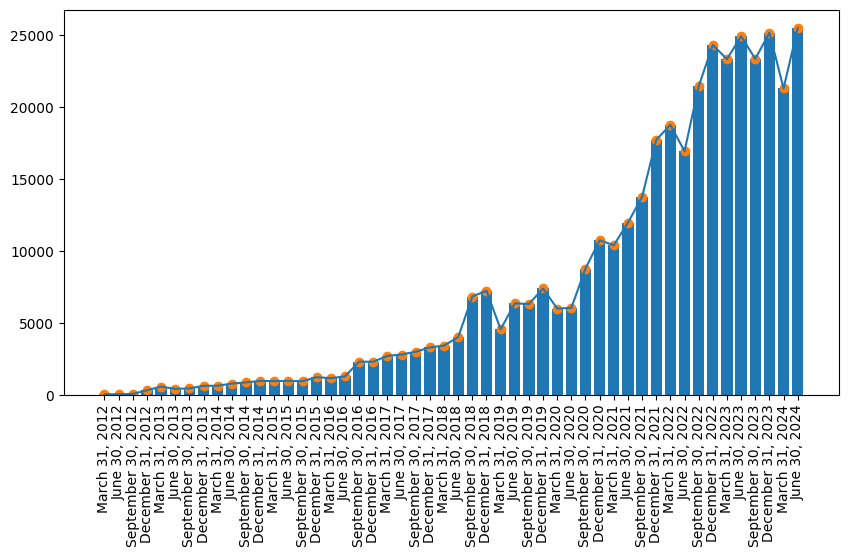

In [13]:
plt.figure(figsize=(10,5))

plt.xticks(rotation=90)
plt.bar(df_tesla['Fecha'][::-1],df_tesla['Revenue'][::-1]) #para ordenar el tiempo se usa el [::-1]
plt.plot(df_tesla['Fecha'][::-1],df_tesla['Revenue'][::-1]) #grafico de lineas
plt.scatter(df_tesla['Fecha'][::-1],df_tesla['Revenue'][::-1]) #grafico puntos
#buscar opciones en matplot lib graphs